In [2]:
%load_ext autoreload
%autoreload 2

import pdb
import torch
import multiprocessing
import pickle, os
import numpy as np
import cvxpy as cp

from torch.autograd import Variable
import concurrent.futures
import matplotlib.pyplot as plt
%matplotlib inline

from free_flyer.free_flyer import FreeFlyer
from free_flyer.utils import *
from solvers.coco_ff import CoCo_FF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def train_horizon_N(N, device_id=0):
    config_fn = './free_flyer/config/default_horizon_{}.p'.format(N)

    config_file = open(config_fn,'rb')
    dataset_name, _, _ = pickle.load(config_file); config_file.close()

    relative_path = os.getcwd()
    dataset_fn = relative_path + '/free_flyer/data/' + dataset_name

    train_fn = os.path.join(dataset_fn, 'train_horizon_{}.p'.format(N))
    train_file = open(train_fn,'rb')
    train_data = pickle.load(train_file)
    train_file.close()
    x_train = train_data[1]
    y_train = train_data[3]

    test_fn = os.path.join(dataset_fn, 'test_horizon_{}.p'.format(N))
    test_file = open(test_fn,'rb')
    test_data = pickle.load(test_file)
    p_test, x_test, u_test, y_test, c_test, times_test = test_data
    test_file.close()

    n_test = x_test.shape[0]

    system = 'free_flyer'
    prob_features = ['x0', 'obstacles_map']

    prob = FreeFlyer(config=config_fn)
    mlopt_cnn = MLOPT_FF(system, prob, prob_features)

    n_features = 4
    mlopt_cnn.construct_strategies(n_features, train_data)

    print('Number of strategies for horizon {}: {}'.format(N, mlopt_cnn.n_strategies))

    mlopt_cnn.setup_network(device_id=device_id)
    mlopt_cnn.model_fn = 'models/mloptff_horizon_{}.pt'.format(N)

    mlopt_cnn.training_params['TRAINING_ITERATIONS'] = 1500
    mlopt_cnn.train(train_data=train_data, verbose=True)

In [3]:
def train_horizons(horizons):
    device_id = horizons[0]
    horizons = horizons[1:]
    for horizon in horizons:
        train_horizon_N(horizon, device_id=device_id)

In [ ]:
with concurrent.futures.ProcessPoolExecutor() as executor:
    horizons = range(6, 13)
    horizons_A = [0,12,10,8,6]
    horizons_B = [1,11,9,7]
    horizons = [horizons_A, horizons_B]
    results = executor.map(train_horizons, horizons)

Number of strategies for horizon 11: 2859
Number of strategies for horizon 12: 3920
loss:   4.620359420776367,   acc:  0.15625
loss:   4.660265922546387,   acc:  0.21875


In [8]:
def test_strategy(N):
    NPROBS = 500

    config_fn = './free_flyer/config/default_horizon_{}.p'.format(N)

    config_file = open(config_fn,'rb')
    dataset_name, _, _ = pickle.load(config_file); config_file.close()

    relative_path = os.getcwd()
    dataset_fn = relative_path + '/free_flyer/data/' + dataset_name

    train_fn = os.path.join(dataset_fn, 'train_horizon_{}.p'.format(N))
    train_file = open(train_fn,'rb')
    train_data = pickle.load(train_file)
    train_file.close()

    system = 'free_flyer'
    prob_features = ['x0', 'obstacles_map']

    config_fn = './free_flyer/config/default_horizon_{}.p'.format(N)
    prob = FreeFlyer(config=config_fn)
    mlopt_cnn = MLOPT_FF(system, prob, prob_features)

    n_features = 4
    mlopt_cnn.construct_strategies(n_features, train_data)
    mlopt_cnn.setup_network(device_id=-1)

    model_fn = 'models/mloptff_horizon_{}.pt'.format(N)
    mlopt_cnn.load_network(model_fn)

    velmin = -0.2
    velmax = 0.2
    posmin = np.zeros(2)
    ft2m = 0.3048
    posmax = ft2m*np.array([12.,9.])
    max_box_size = 0.75
    min_box_size = 0.25
    box_buffer = 0.025
    border_size = 0.05

    batch_percent_success = {}
    batch_true_cost = {}
    batch_cost = {}
    batch_cost_ratio = {}
    batch_con_tol = {}

    for N_OBS in range(6, 13):
        print('Starting {} obstacles'.format(N_OBS))
        n_solved = 0.
        success_count = 0.
        gurobi_mlopt_fail = 0

        toggle_obstacles = True
        toggle_count = 0
        problem_count = 0

        batch_true_cost[N_OBS] = []
        batch_cost[N_OBS] = []
        batch_cost_ratio[N_OBS] = []
        batch_con_tol[N_OBS] = []

        mlopt_cnn.problem.n_obs = N_OBS
        mlopt_cnn.problem.init_mlopt_problem()
        mlopt_cnn.problem.init_bin_problem()
        
        while n_solved < NPROBS:
            problem_count += 1
            if problem_count % 20 == 0:
                print('Done with problem {}'.format(n_solved))
                dump_fn = './free_flyer/config/testfile_horizon_{}.txt'.format(N)
                file = open(dump_fn,'w')
                file.write('On obstacle {}\n'.format(N_OBS))
                file.write('Problems solved: {}/{}'.format(n_solved, NPROBS))
                file.close()

            if problem_count % 50 == 0:
                print('Saving config at problem {}'.format(n_solved))
                relative_path = os.getcwd()
                dataset_fn = relative_path + '/free_flyer/data/' + 'horizon_{}_results'.format(N)
                config_fn = os.path.join(relative_path, 'free_flyer/config', 'results_horizon_{}'.format(N) + '.p')

                config = [batch_percent_success, batch_true_cost, batch_cost, batch_cost_ratio, batch_con_tol]
                outfile = open(config_fn,"wb")
                pickle.dump(config,outfile); outfile.close()

            if toggle_obstacles:
                x0 = np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
                           velmin + (velmax-velmin)*np.random.rand(2)))
                obstacles = find_obs(x0, N_OBS, posmin, posmax, \
                    border_size, box_buffer, min_box_size, max_box_size)
                if len(obstacles) is not N_OBS:
                    continue
            else:
                obstacles = random_obs(N_OBS, posmin, posmax, border_size, box_buffer, \
                  min_box_size, max_box_size)
                x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
            if len(obstacles) is not N_OBS:
                continue

            obstacles = np.reshape(np.concatenate(obstacles, axis=0), (mlopt_cnn.problem.n_obs,4)).T

            prob_params = {}
            prob_params['x0'] = x0
            prob_params['obstacles'] = obstacles
            prob_params['xg'] = np.hstack((0.9*posmax, np.zeros(2)))

            try:
                prob_success, true_cost, solve_time, optvals = mlopt_cnn.problem.solve_micp(prob_params)
            except (KeyboardInterrupt, SystemExit):
                raise
            except:
                print('Solver failed for MICP')
                gurobi_mlopt_fail += 1
                continue

            if not prob_success:
                continue

            try:
                prob_success, cost, total_time, n_evals, mlopt_vals = mlopt_cnn.forward(prob_params)
            except (KeyboardInterrupt, SystemExit):
                raise
            except:
                print('Solver failed for QCQP')
                continue

            if prob_success:
                slack_vars = mlopt_vals[-1]

                if np.any(slack_vars < 0.):
                    # If any slack variable returns negative value
                    warn_fn = './free_flyer/config/testwarn_horizon_{}.txt'.format(N)
                    
                    file = open(warn_fn,'w')
                    file.write('Found invalid slack variable soln!')
                    file.close()
                    continue
                elif np.sum(slack_vars) < 1e-3:
                    # Only consider cost ratios for feasible trajectories
                    success_count += 1
                    batch_true_cost[N_OBS] += [true_cost]
                    batch_cost_ratio[N_OBS] += [cost / true_cost]
                batch_cost[N_OBS] += [cost]
                batch_con_tol[N_OBS] += [np.sum(slack_vars)]

                toggle_count += 1
                if toggle_count % 5 == 0:
                    toggle_obstacles = not toggle_obstacles

            n_solved+=1

        batch_percent_success[N_OBS] = success_count / NPROBS

    # write out config
    relative_path = os.getcwd()
    dataset_fn = relative_path + '/free_flyer/data/' + 'horizon_{}_results'.format(N)
    config_fn = os.path.join(relative_path, 'free_flyer/config', 'results_horizon_{}'.format(N) + '.p')

    config = [batch_percent_success, batch_true_cost, batch_cost, batch_cost_ratio, batch_con_tol]
    outfile = open(config_fn,"wb")
    pickle.dump(config,outfile); outfile.close()

In [ ]:
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     horizons = range(6, 13)
#     horizons = [6,7]
#     results = executor.map(test_strategy, horizons)
# processes = []
# for N in [6,7]:
#     p = multiprocessing.Process(target=test_strategy, args=[N])
#     p.start()
#     processes.append(p)
    
# for p in processes:
#     p.join()

horizon = 7
test_strategy(horizon)

Loading presaved classifier model from models/mloptff_horizon_7.pt
Starting 6 obstacles
Done with problem 12.0


In [10]:
# N = 6
# for N in range(6,13):
#     relative_path = os.getcwd()
#     config_fn = os.path.join(relative_path, 'free_flyer/config', 'results_horizon_{}'.format(N) + '.p')
#     config_file = open(config_fn,'rb')
#     batch_percent_success, batch_true_cost, batch_cost, batch_cost_ratio, batch_con_tol = pickle.load(config_file); config_file.close()
#     print(batch_percent_success[6])

0.88
0.93
0.89
0.84
0.65
0.72
0.6


# Plot results

In [3]:
import math
import seaborn as sns
sns.set(font_scale=1.5, font="serif", style="whitegrid")
import pandas as pd

flierprops = {'alpha':0.2}
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [12]:
import math
import seaborn as sns
sns.set(font_scale=1.5, font="serif", style="whitegrid")
import pandas as pd
import h5py
import matplotlib

flierprops = {'alpha':0.2}

params = {'backend': 'ps',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
#               'axes.labelsize': 12, # fontsize for x and y labels (was 12 and before 10)
#               'axes.titlesize': 12,
              'font.size': 90, # was 12 and before 10
              'legend.fontsize': 12, # was 12 and before 10
#               'xtick.labelsize': 12,
#               'ytick.labelsize': 12,
              'text.usetex': True,
              'font.family': 'serif',
              'font.sans-serif':['Helvetica Neue']
    }

params = {
#     'backend': 'ps',
#               'text.latex.preamble': ['\\usepackage{gensymb}'],
#               'axes.labelsize': 12, # fontsize for x and y labels (was 12 and before 10)
#               'axes.titlesize': 12,
#               'font.size': 12, # was 12 and before 10
              'legend.fontsize': 26, # was 12 and before 10
#               'xtick.labelsize': 12,
#               'ytick.labelsize': 12,
#               'text.usetex': True,
#               'font.family': 'serif',
#               'font.sans-serif':['Helvetica Neue']
    }

sns.set(font_scale=2.)
matplotlib.rcParams.update(params)

In [4]:
relative_path = os.getcwd()
percent_successes = {}
con_tols = {}
cost_ratios = {}

horizons = range(6,13)
for N in horizons:
    results_fn = os.path.join(relative_path, 'free_flyer/config', 'results_horizon_{}'.format(N) + '.p')
    results_file = open(results_fn,'rb')
    batch_percent_success, batch_true_cost, batch_cost, batch_cost_ratio, batch_con_tol = pickle.load(results_file)
    results_file.close()

    percent_successes[N] = batch_percent_success
    con_tols[N] = batch_con_tol
    cost_ratios[N] = batch_cost_ratio

# Results

In [5]:
percent_successes

{6: {6: 0.928, 7: 0.904, 8: 0.92, 9: 0.86, 10: 0.848, 11: 0.85, 12: 0.858},
 7: {6: 0.894, 7: 0.902, 8: 0.886, 9: 0.866, 10: 0.822, 11: 0.802, 12: 0.814},
 8: {6: 0.856, 7: 0.864, 8: 0.806, 9: 0.79, 10: 0.768, 11: 0.724, 12: 0.742},
 9: {6: 0.868, 7: 0.818, 8: 0.82, 9: 0.814, 10: 0.77, 11: 0.764, 12: 0.748},
 10: {6: 0.806, 7: 0.802, 8: 0.726, 9: 0.736, 10: 0.718, 11: 0.628, 12: 0.652},
 11: {6: 0.774, 7: 0.748, 8: 0.744, 9: 0.684, 10: 0.616, 11: 0.592, 12: 0.608},
 12: {6: 0.708, 7: 0.666, 8: 0.614, 9: 0.622, 10: 0.61, 11: 0.564, 12: 0.498}}

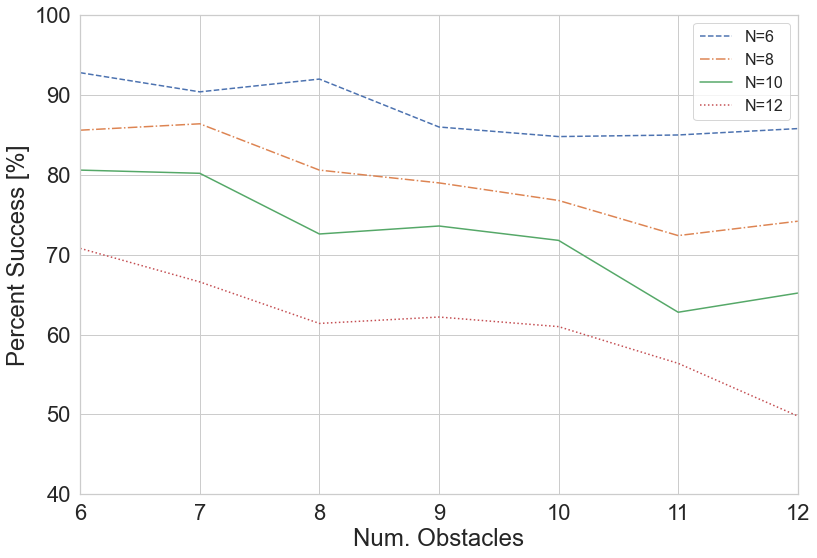

In [50]:
linestyles = ['--', '-.', '-', ':']

plot_horizons = [6,8,10,12]
for ii, N in enumerate(plot_horizons):
    batch_percent_success = percent_successes[N]
    x_labels = [ii for ii in range(6,13)]
    y_labels = [100.*batch_percent_success[x] for x in x_labels]
    ax1 = sns.lineplot(x=x_labels, y=y_labels, palette="Set3", label='N={}'.format(N), linewidth=1.5)
    ax1.lines[ii].set_linestyle(linestyles[ii])
    # ax1.set(xlabel="", ylabel="Percent Success")

ax1.set(xlabel="Num. Obstacles", ylabel="Percent Success [%]")
# ax1.grid(False)

yticks =  [10*ii for ii in range(11)]
ax1.set_yticks(yticks)

plt.tight_layout()
plt.legend(loc='upper right', fontsize='16')
plt.xlim([6,12])
plt.ylim([40.,100.])

# sns.set_style("whitegrid")
st = sns.axes_style("whitegrid")
sns.set_color_codes("dark")

figure = ax1.get_figure()
# figure.savefig("percent_success_generalization.pdf")

In [108]:
results = {}
results['horizon'] = []
results['n_obs'] = []
results['tol'] = []
for horizon in range(6,13):
    for n_obs in range(6,13):
        results['horizon'].extend([horizon]*len(con_tols[horizon][n_obs]))
        results['n_obs'].extend([n_obs]*len(con_tols[horizon][n_obs]))

        # make sure to normalize violations by n_obs and horizon
        results['tol'].extend([1./float(n_obs*horizon)*ct for ct in con_tols[horizon][n_obs]])
results = pd.DataFrame(results)

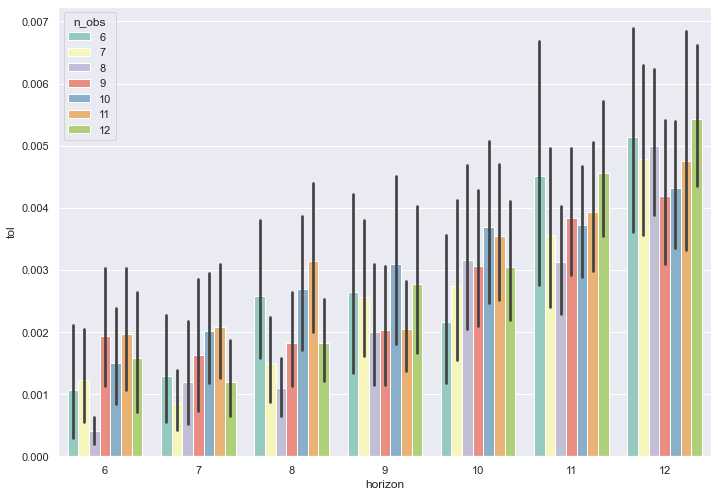

In [112]:
ax1 = sns.barplot(x='horizon', y='tol', data=results, hue='n_obs', order=[6,7,8,9,10,11,12], palette="Set3")

figure = ax1.get_figure()
figure.savefig("violations.png")

In [116]:
results = {}
results['horizon'] = []
results['n_obs'] = []
results['cost_ratio'] = []
for horizon in range(6,13):
    for n_obs in range(6,13):
        results['horizon'].extend([horizon]*len(cost_ratios[horizon][n_obs]))
        results['n_obs'].extend([n_obs]*len(cost_ratios[horizon][n_obs]))

        results['cost_ratio'].extend([100.*cr for cr in cost_ratios[horizon][n_obs]])
results = pd.DataFrame(results)

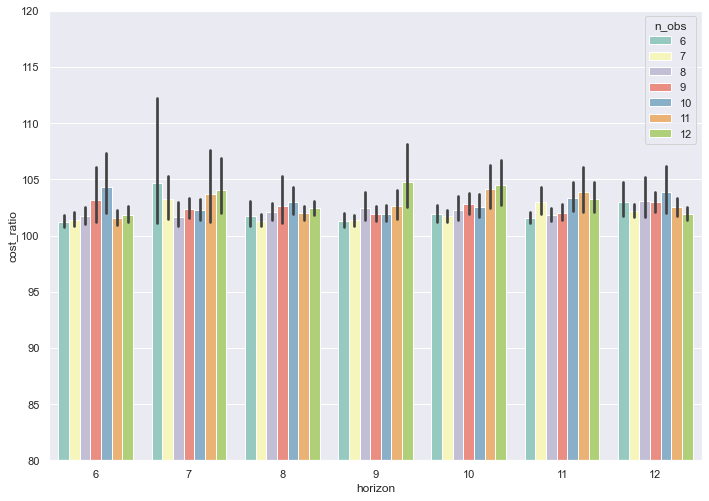

In [119]:
ax1 = sns.barplot(x='horizon', y='cost_ratio', data=results, hue='n_obs', order=[6,7,8,9,10,11,12], palette="Set3")

plt.ylim([80.,120.])

figure = ax1.get_figure()
figure.savefig("cost_ratios.png")